# Data processing

Download, save, visualize and load dataset.



In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = "../../data/"
resolution = "5.625deg"

## 1. geopotential_500, temperature_850

### The signal

- Test: years 2017 and 2018
- Validation: year 2016
- Train: year 2015

In [127]:
def load_data(path, train_years=slice('2015', '2015'), val_years=slice('2016', '2016'), 
              test_years=slice('2017', '2018')):
    """
    Args:
        path: Path to nc files
        var: variable. Geopotential = 'z', Temperature = 't'
        years: slice for time window
    Returns:
        dataset: Concatenated dataset for 2017 and 2018
    """
    zpath = path + 'geopotential_500'
    tpath = path + 'temperature_850'
    
    z = xr.open_mfdataset(zpath+'/*.nc', combine='by_coords')['z']
    t = xr.open_mfdataset(tpath+'/*.nc', combine='by_coords')['t']
    
    try:
        # z = z.sel(level=500).drop('level')
        #z = z.drop('level')
        z = z.assign_coords(level=1)
    except ValueError:
        pass

    try:
        # t = t.sel(level=850).drop('level')
        #t = t.drop('level')
        t = t.assign_coords(level=1)
    except ValueError:
        pass
    
    dataset = xr.merge([z, t])
    #dataset = xr.concat([z, t], 'level').transpose('time', 'lat', 'lon', 'level')
    
    return dataset.sel(time=train_years), dataset.sel(time=val_years), dataset.sel(time=test_years)
    

In [128]:
train, val, test = load_data(DATA_DIR + resolution + "/")
N = train.dims['lat']*train.dims['lon']

### Structure of the samples

Each element of each xarray sample is organized as: (Latitude_value, [longitude_list], [signal_value_list])

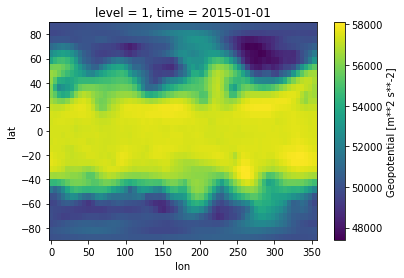

In [129]:
train.z[0].plot()

In [6]:
train.z[0]

<xarray.DataArray 'z' (lat: 32, lon: 64)>
dask.array<getitem, shape=(32, 64), dtype=float32, chunksize=(32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    time     datetime64[ns] 2015-01-01
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [7]:
for a in train.z[0]:
    print(a.lat.values, a.lon.values, a.values, '\n')

-87.1875 [  0.      5.625  11.25   16.875  22.5    28.125  33.75   39.375  45.
  50.625  56.25   61.875  67.5    73.125  78.75   84.375  90.     95.625
 101.25  106.875 112.5   118.125 123.75  129.375 135.    140.625 146.25
 151.875 157.5   163.125 168.75  174.375 180.    185.625 191.25  196.875
 202.5   208.125 213.75  219.375 225.    230.625 236.25  241.875 247.5
 253.125 258.75  264.375 270.    275.625 281.25  286.875 292.5   298.125
 303.75  309.375 315.    320.625 326.25  331.875 337.5   343.125 348.75
 354.375] [50076.156 50114.47  50152.797 50191.11  50221.75  50252.406 50283.062
 50306.047 50321.375 50336.703 50344.36  50344.36  50344.36  50344.36
 50336.703 50321.375 50313.703 50306.047 50290.72  50275.39  50267.734
 50260.062 50260.062 50260.062 50260.062 50267.734 50283.062 50306.047
 50329.03  50359.688 50390.344 50420.984 50459.297 50489.953 50528.266
 50558.92  50589.58  50620.22  50650.875 50673.86  50689.188 50704.516
 50712.17  50719.844 50712.17  50704.516 50696.86  5

### The graphs

In order to use DeepSphere convolutional kernels, the input samples need to be:
- A 1d vector with the signal
- the Graph Laplacian 

/!\ Correspondence of the vertices
-> We used 'SOFT' sampling, an improved version of the Driscoll-Heally sampling that does not include the poles in order to fit the signal data

1. Sample the vertices  
    1.1. Create weight matrix  
    1.2. Get the indexes corresponding to the sampled vectors (for the signal)  
    
2. Order the vertices in a 1D vector (torch tensor)
3. Compute the Laplacian (torch tensor)

TO DO:
- Rasterizing method?

In [24]:
import pygsp
from pygsp import plotting

In [15]:
graph = pygsp.graphs.SphereEquiangular(bandwidth=(16, 32), sampling='SOFT')

print('MSE between graph and signal vertex latitudes:', sum((train.z[0].lat.values - graph.lat[:, 0] * (180/np.pi))**2))
print('MSE between graph and signal vertex longitudes:', sum((train.z[0].lon.values - graph.lon[0] * (180/np.pi))**2))
    

MSE between graph and signal vertex latitudes: 9.533384039595928e-28
MSE between graph and signal vertex longitudes: 1.868022623563356e-27


In [32]:
train.z[0].values

array([[50076.156, 50114.47 , 50152.797, ..., 49976.547, 49999.53 ,
        50037.844],
       [50237.08 , 50313.703, 50398.   , ..., 50106.812, 50129.797,
        50175.78 ],
       [49846.28 , 49961.22 , 50083.83 , ..., 49930.566, 49823.28 ,
        49784.97 ],
       ...,
       [50114.47 , 50191.11 , 50214.094, ..., 49922.906, 49922.906,
        49999.53 ],
       [49700.688, 49739.   , 49800.297, ..., 49670.03 , 49654.703,
        49670.03 ],
       [49876.92 , 49884.594, 49899.92 , ..., 49876.92 , 49869.266,
        49869.266]], dtype=float32)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f3ea5b43490>)

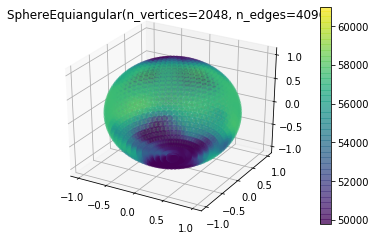

In [39]:
graph.plot_signal(train.z[0].values.reshape((32*64, 1)), vertex_size=50)

### Data generator

This data generator needs to provide:
- normalized data 
- in correct shape
- consisting in samples and labels
- as a torch tensor


In [150]:
from torch.utils.data import Dataset

In [151]:
class WeatherBenchDataset(Dataset):
    
    def __init__(self, data, delta_t, mean=None, std=None):
        
        data = [data[var] for var in ['z', 't']]
        data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        
        self.data = data
        self.delta_t = delta_t
        
        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std
        
        # Number of samples
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.N = self.data.shape[1]*self.data.shape[2]
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        X = self.data.isel(time=idx).values.reshape((self.N, 2))
        y = self.data.isel(time=idx+self.delta_t).values.reshape((self.N, 2))
        
        return torch.Tensor(X), torch.Tensor(y)

### The models

https://github.com/ArcaniteSolutions/deepsphere

In [11]:
from torch import nn

from deepsphere.models.spherical_unet.encoder import SphericalChebBN2, SphericalChebPool
from deepsphere.layers.chebyshev import SphericalChebConv

In [12]:
class Encoder(nn.Module):
    """Encoder for the Spherical UNet.
    """

    def __init__(self, channels_in, kernel_size, pooling, laplacians):
        """Initialization.
        Args:
            pooling (:obj:`torch.nn.Module`): pooling layer.
            laps (list): List of laplacians.
            kernel_size (int): polynomial degree.
        """
        super().__init__()
        self.depth = len(laps)//2 + 1
        self.pooling = pooling
        self.kernel_size = kernel_size
        
        self.enc_l5 = SphericalChebBN2(channels_in, 32, 64, laps[2], self.kernel_size)
        self.enc_l4 = SphericalChebBNPool(64, 128, laps[1], self.pooling, self.kernel_size)
        self.enc_l3 = SphericalChebBNPool(128, 256, laps[0], self.pooling, self.kernel_size)
        #self.enc_l2 = SphericalChebBNPool(256, 512, laps[2], self.pooling, self.kernel_size)
        #self.enc_l1 = SphericalChebBNPool(512, 512, laps[1], self.pooling, self.kernel_size)
        #self.enc_l0 = SphericalChebPool(512, 512, laps[0], self.pooling, self.kernel_size)
        

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input [batch x vertices x channels/features]
        Returns:
            x_enc* :obj: `torch.Tensor`: output [batch x vertices x channels/features]
        """
        x_enc5 = self.enc_l5(x)
        x_enc4 = self.enc_l4(x_enc5)
        x_enc3 = self.enc_l3(x_enc4)
        #x_enc2 = self.enc_l2(x_enc3)
        #x_enc1 = self.enc_l1(x_enc2)
        #x_enc0 = self.enc_l0(x_enc1)

        #return x_enc0, x_enc1, x_enc2, x_enc3, x_enc4
        return x_enc3, x_enc4

class Decoder(nn.Module):
    """The decoder of the Spherical UNet.
    """

    def __init__(self, channels_out, kernel_size, unpooling, laplacians):
        """Initialization.
        Args:
            unpooling (:obj:`torch.nn.Module`): The unpooling object.
            laps (list): List of laplacians.
        """
        super().__init__()
        self.unpooling = unpooling
        self.kernel_size = kernel_size
        
        #self.dec_l1 = SphericalChebBNPoolConcat(512, 512, laps[1], self.unpooling, self.kernel_size)
        #self.dec_l2 = SphericalChebBNPoolConcat(512, 256, laps[2], self.unpooling, self.kernel_size)
        self.dec_l3 = SphericalChebBNPoolConcat(256, 128, laps[0], self.unpooling, self.kernel_size)
        self.dec_l4 = SphericalChebBNPoolConcat(128, 64, laps[1], self.unpooling, self.kernel_size)
        self.dec_l5 = SphericalChebBNPoolCheb(64, 32, channels_out, laps[2], self.unpooling, self.kernel_size)
        # Switch from Logits to Probabilities if evaluating model
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x_enc3, x_enc4):
        """Forward Pass.
        Args:
            x_enc* (:obj:`torch.Tensor`): input tensors.
        Returns:
            :obj:`torch.Tensor`: output after forward pass.
        """
        #x = self.dec_l1(x_enc0, x_enc1)
        #x = self.dec_l2(x, x_enc2)
        x = self.dec_l3(x, x_enc3)
        x = self.dec_l4(x, x_enc4)
        x = self.dec_l5(x)
        if not self.training:
            x = self.softmax(x)
        return x

class SphericalUNet(nn.Module):
    """Spherical GCNN Autoencoder.
    """

    def __init__(self, N, depth, channels_in, channels_out, laplacian_type, kernel_size, ratio, pooling):
        """Initialization.
        Args:
            N (int): Number of pixels in the input image
            depth (int): The depth of the UNet, which is bounded by the N and the type of pooling
            kernel_size (int): chebychev polynomial degree
            ratio (float): Parameter for equiangular sampling -> width/height
        """
        super().__init__()
        self.ratio = ratio
        self.kernel_size = kernel_size
        
        self.pooling_class = Equiangular(mode=pooling)
        self.laplacians = get_equiangular_laplacians(N, depth, self.ratio, laplacian_type)

        self.encoder = Encoder(channels_in, self.kernel_size, self.pooling_class.pooling, self.laplacians)
        self.decoder = Decoder(channels_out, self.kernel_size, self.pooling_class.unpooling, self.laplacians)

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.
        Returns:
            :obj:`torch.Tensor`: output
        """
        x_encoder = self.encoder(x)
        output = self.decoder(*x_encoder)
        return output

### Train 

In [69]:
from torch.utils.data import DataLoader

In [153]:
delta_t = 3*24
batch_size = 32

In [157]:
dataset_train = WeatherBenchDataset(train, delta_t)
dataset_val = WeatherBenchDataset(val, delta_t, dataset_train.mean, dataset_train.std)

dataloader_train = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=12)
dataloader_validation = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=12)

NameError: name 'train_set' is not defined

In [ ]:
ratio = train.dims['lon']/train.dims['lat']
n_samples = len(train.z)


